In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import os

from ensemblecalibration.data.synthetic.binary_new import BinaryExperiment
from ensemblecalibration.meta_model import (
    CredalSetCalibrator,
    LinearCalibrator,
    DirichletCalibrator,
    TemperatureScalingCalibrator,
    MLPCalW
)
from ensemblecalibration.losses.proper_losses import GeneralizedBrierLoss, GeneralizedLogLoss
from ensemblecalibration.data.dataset import MLPDataset
from ensemblecalibration.data.synthetic import create_synthetic_dataset
from ensemblecalibration.meta_model.train import train_model
from ensemblecalibration.utils.plot_functions import plot_ens_comb_cal
from ensemblecalibration.cal_estimates import get_skce_ul, get_ece_kde, brier_obj, mmd_kce
from ensemblecalibration.config import load_config

In [2]:
# losses to test
losses = {
    "brier": GeneralizedBrierLoss(),
    "log": GeneralizedLogLoss()
}
# metrics to test: 
metrics = {
    "skce": get_skce_ul,
    "ece": get_ece_kde,
    "brier": brier_obj,
    "mmd": mmd_kce
}
# recalibration methods
cal_methods = {
    "dirichlet": DirichletCalibrator,
    "temperature": TemperatureScalingCalibrator
}

### 1. Experiment: Gaussian Process Data


In [4]:
# load dictionary with configuration data:
config = load_config("../ensemblecalibration/configs/gp_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]

In [5]:
# create datasets
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)
# train_set.indices


In [6]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

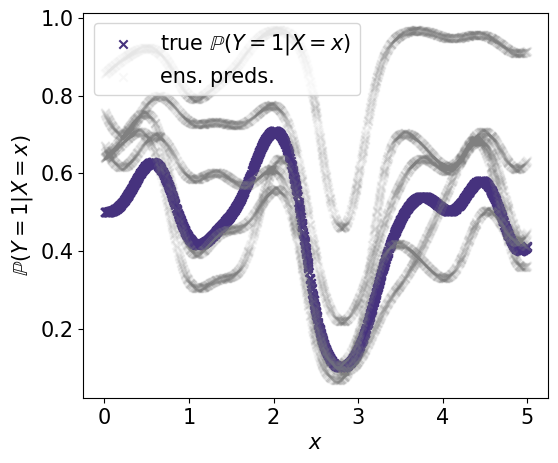

In [7]:
# plot data
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/gp/synthetic_data_gp.png", dpi=300)

Epoch 1/500: train=0.4872, val=0.4558
Epoch 10/500: train=0.4620, val=0.4325
Epoch 20/500: train=0.4585, val=0.4291
Epoch 30/500: train=0.4565, val=0.4280
Epoch 40/500: train=0.4551, val=0.4286
Epoch 50/500: train=0.4557, val=0.4293
Epoch 60/500: train=0.4529, val=0.4300
Epoch 70/500: train=0.4531, val=0.4311
Early stopping at epoch 80
Best epoch: 30, Best val loss: 0.4279979169368744
Stopped early at epoch 80
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_joint_DirichletCalibrator.png


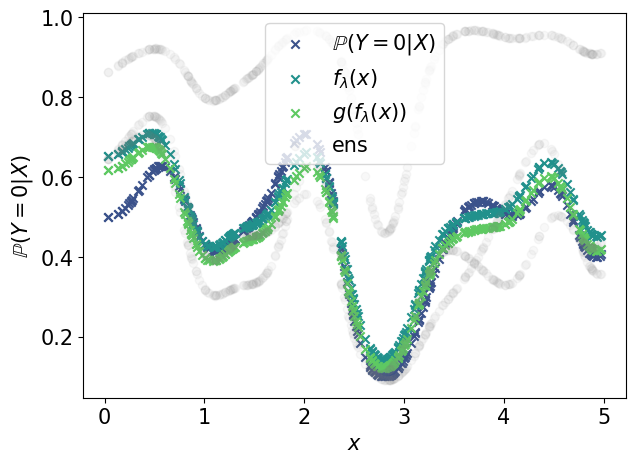

Epoch 1/500: train=0.4787, val=0.4453
Epoch 10/500: train=0.4610, val=0.4291
Epoch 20/500: train=0.4596, val=0.4272
Epoch 30/500: train=0.4584, val=0.4257
Epoch 40/500: train=0.4578, val=0.4253
Epoch 50/500: train=0.4577, val=0.4248
Epoch 60/500: train=0.4570, val=0.4248
Epoch 70/500: train=0.4578, val=0.4247
Epoch 80/500: train=0.4562, val=0.4243
Epoch 90/500: train=0.4558, val=0.4234
Epoch 100/500: train=0.4552, val=0.4235
Epoch 110/500: train=0.4554, val=0.4239
Epoch 120/500: train=0.4551, val=0.4236
Epoch 130/500: train=0.4538, val=0.4223
Epoch 140/500: train=0.4539, val=0.4232
Epoch 150/500: train=0.4545, val=0.4239
Epoch 160/500: train=0.4546, val=0.4235
Epoch 170/500: train=0.4547, val=0.4223
Epoch 180/500: train=0.4540, val=0.4227
Epoch 190/500: train=0.4543, val=0.4218
Epoch 200/500: train=0.4543, val=0.4231
Epoch 210/500: train=0.4554, val=0.4235
Epoch 220/500: train=0.4541, val=0.4224
Epoch 230/500: train=0.4547, val=0.4222
Epoch 240/500: train=0.4541, val=0.4236
Epoch 250/5

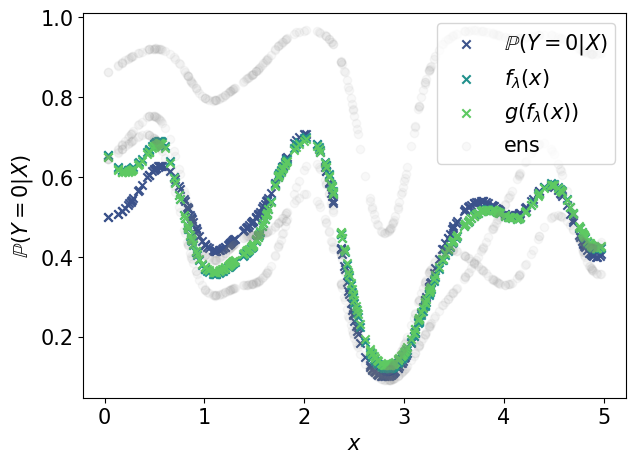

Epoch 1/500: train=0.5839, val=0.4459
Epoch 10/500: train=0.5349, val=0.4314
Epoch 20/500: train=0.5155, val=0.4324
Epoch 30/500: train=0.5015, val=0.4323
Epoch 40/500: train=0.4907, val=0.4323
Epoch 50/500: train=0.4842, val=0.4323
Early stopping at epoch 59
Best epoch: 9, Best val loss: 0.43140241503715515
Stopped early at epoch 59
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_joint_LinearCalibrator.png


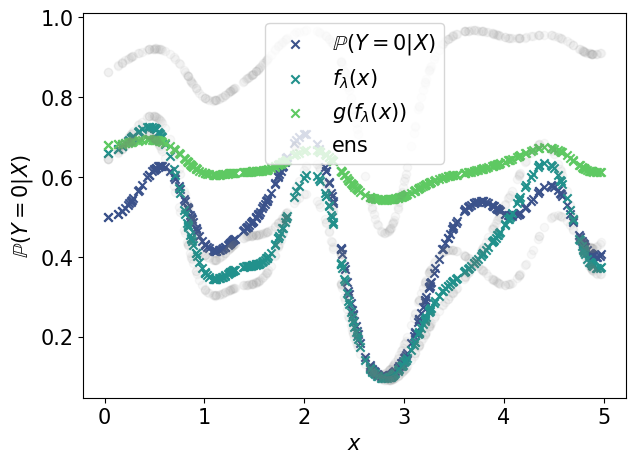

Cycle 1/500: comb_loss=0.4828, cal_loss=0.4794, val=0.4504
Cycle 5/500: comb_loss=0.4664, cal_loss=0.4632, val=0.4351
Cycle 10/500: comb_loss=0.4622, cal_loss=0.4606, val=0.4298
Cycle 15/500: comb_loss=0.4593, cal_loss=0.4585, val=0.4281
Cycle 20/500: comb_loss=0.4587, cal_loss=0.4586, val=0.4271
Cycle 25/500: comb_loss=0.4594, cal_loss=0.4572, val=0.4262
Cycle 30/500: comb_loss=0.4585, cal_loss=0.4569, val=0.4258
Cycle 35/500: comb_loss=0.4577, cal_loss=0.4568, val=0.4257
Cycle 40/500: comb_loss=0.4570, cal_loss=0.4560, val=0.4259
Cycle 45/500: comb_loss=0.4566, cal_loss=0.4548, val=0.4256
Cycle 50/500: comb_loss=0.4563, cal_loss=0.4554, val=0.4256
Cycle 55/500: comb_loss=0.4568, cal_loss=0.4559, val=0.4255
Cycle 60/500: comb_loss=0.4565, cal_loss=0.4543, val=0.4255
Cycle 65/500: comb_loss=0.4560, cal_loss=0.4552, val=0.4249
Cycle 70/500: comb_loss=0.4553, cal_loss=0.4549, val=0.4251
Cycle 75/500: comb_loss=0.4556, cal_loss=0.4547, val=0.4250
Cycle 80/500: comb_loss=0.4553, cal_loss=0

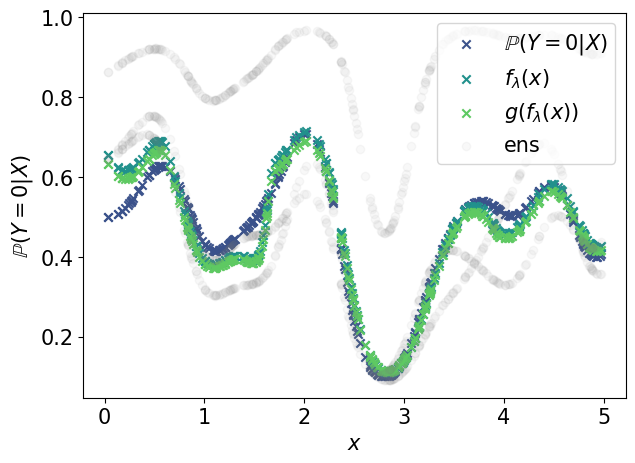

Cycle 1/500: comb_loss=0.4882, cal_loss=0.4854, val=0.4568
Cycle 5/500: comb_loss=0.4646, cal_loss=0.4644, val=0.4338
Cycle 10/500: comb_loss=0.4631, cal_loss=0.4628, val=0.4300
Cycle 15/500: comb_loss=0.4607, cal_loss=0.4611, val=0.4288
Cycle 20/500: comb_loss=0.4598, cal_loss=0.4609, val=0.4277
Cycle 25/500: comb_loss=0.4590, cal_loss=0.4599, val=0.4272
Cycle 30/500: comb_loss=0.4600, cal_loss=0.4597, val=0.4269
Cycle 35/500: comb_loss=0.4600, cal_loss=0.4587, val=0.4266
Cycle 40/500: comb_loss=0.4593, cal_loss=0.4586, val=0.4262
Cycle 45/500: comb_loss=0.4586, cal_loss=0.4571, val=0.4261
Cycle 50/500: comb_loss=0.4578, cal_loss=0.4569, val=0.4256
Cycle 55/500: comb_loss=0.4570, cal_loss=0.4579, val=0.4255
Cycle 60/500: comb_loss=0.4576, cal_loss=0.4569, val=0.4257
Cycle 65/500: comb_loss=0.4576, cal_loss=0.4575, val=0.4256
Cycle 70/500: comb_loss=0.4572, cal_loss=0.4569, val=0.4255
Cycle 75/500: comb_loss=0.4578, cal_loss=0.4577, val=0.4254
Cycle 80/500: comb_loss=0.4558, cal_loss=0

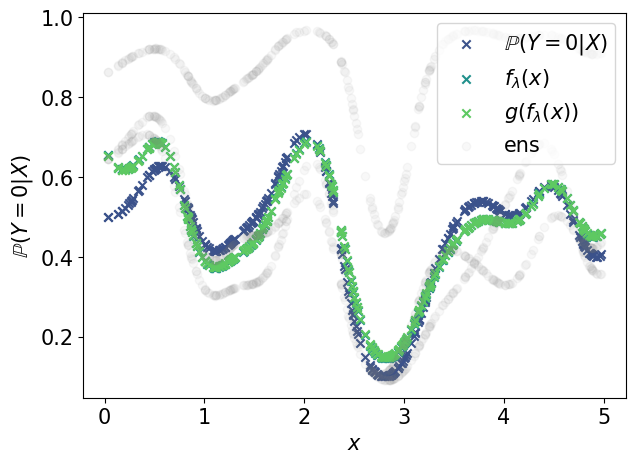

Cycle 1/500: comb_loss=0.4815, cal_loss=0.6374, val=0.4507
Cycle 5/500: comb_loss=0.4651, cal_loss=0.6080, val=0.4326
Cycle 10/500: comb_loss=0.4613, cal_loss=0.5896, val=0.4289
Cycle 15/500: comb_loss=0.4607, cal_loss=0.5753, val=0.4276
Cycle 20/500: comb_loss=0.4594, cal_loss=0.5626, val=0.4264
Cycle 25/500: comb_loss=0.4580, cal_loss=0.5512, val=0.4261
Cycle 30/500: comb_loss=0.4582, cal_loss=0.5384, val=0.4257
Cycle 35/500: comb_loss=0.4591, cal_loss=0.5298, val=0.4257
Cycle 40/500: comb_loss=0.4588, cal_loss=0.5201, val=0.4252
Cycle 45/500: comb_loss=0.4583, cal_loss=0.5134, val=0.4256
Cycle 50/500: comb_loss=0.4562, cal_loss=0.5063, val=0.4255
Cycle 55/500: comb_loss=0.4564, cal_loss=0.5004, val=0.4244
Cycle 60/500: comb_loss=0.4562, cal_loss=0.4958, val=0.4250
Cycle 65/500: comb_loss=0.4568, cal_loss=0.4916, val=0.4247
Cycle 70/500: comb_loss=0.4563, cal_loss=0.4885, val=0.4253
Cycle 75/500: comb_loss=0.4568, cal_loss=0.4856, val=0.4247
Cycle 80/500: comb_loss=0.4564, cal_loss=0

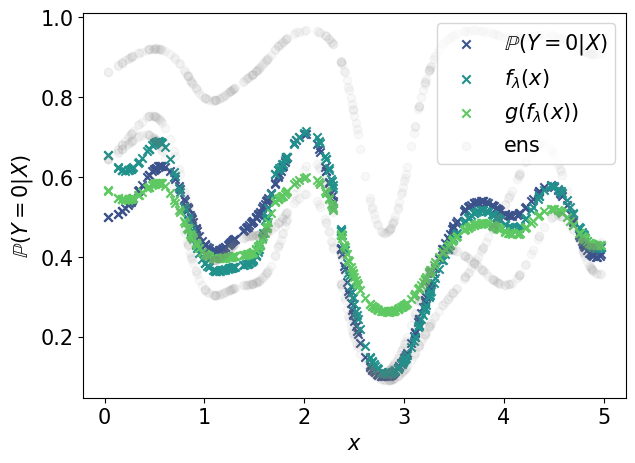

Epoch 1/500: train=0.4870, val=0.4566
Epoch 10/500: train=0.4731, val=0.4433
Epoch 20/500: train=0.4648, val=0.4345
Epoch 30/500: train=0.4607, val=0.4302
Epoch 40/500: train=0.4588, val=0.4282
Epoch 50/500: train=0.4584, val=0.4274
Epoch 60/500: train=0.4577, val=0.4271
Epoch 70/500: train=0.4570, val=0.4270
Epoch 80/500: train=0.4579, val=0.4270
Epoch 90/500: train=0.4573, val=0.4269
Epoch 100/500: train=0.4574, val=0.4269
Epoch 110/500: train=0.4575, val=0.4269
Epoch 120/500: train=0.4564, val=0.4269
Epoch 130/500: train=0.4576, val=0.4268
Epoch 140/500: train=0.4572, val=0.4268
Epoch 150/500: train=0.4574, val=0.4268
Epoch 160/500: train=0.4576, val=0.4268
Epoch 170/500: train=0.4568, val=0.4268
Epoch 180/500: train=0.4580, val=0.4267
Epoch 190/500: train=0.4570, val=0.4267
Epoch 200/500: train=0.4571, val=0.4267
Epoch 210/500: train=0.4580, val=0.4267
Epoch 220/500: train=0.4579, val=0.4267
Epoch 230/500: train=0.4574, val=0.4267
Epoch 240/500: train=0.4569, val=0.4267
Epoch 250/5

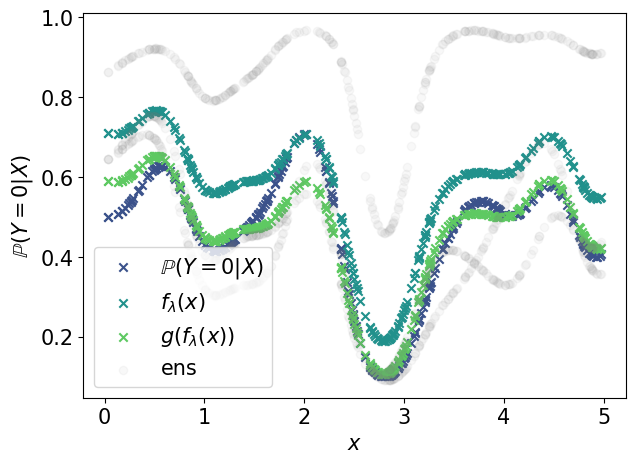

Epoch 1/500: train=0.4883, val=0.4585
Epoch 10/500: train=0.4853, val=0.4582
Epoch 20/500: train=0.4855, val=0.4580
Epoch 30/500: train=0.4852, val=0.4579
Epoch 40/500: train=0.4847, val=0.4578
Epoch 50/500: train=0.4832, val=0.4577
Epoch 60/500: train=0.4840, val=0.4577
Epoch 70/500: train=0.4823, val=0.4577
Epoch 80/500: train=0.4819, val=0.4578
Epoch 90/500: train=0.4822, val=0.4578
Epoch 100/500: train=0.4818, val=0.4579
Early stopping at epoch 110
Best epoch: 60, Best val loss: 0.45770604610443116
Stopped early at epoch 110
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_avg_then_calibrate_TemperatureScalingCalibrator.png


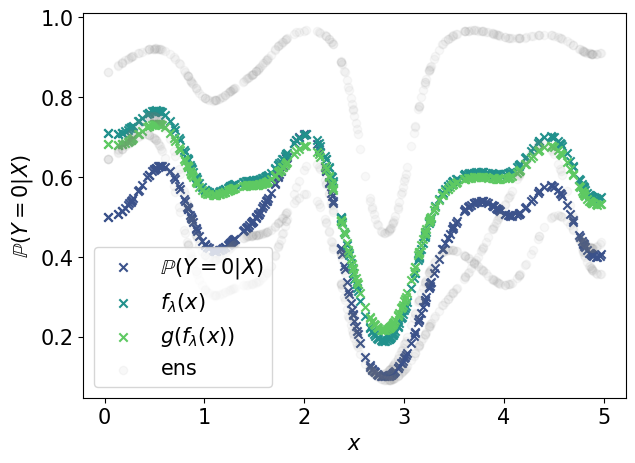

Epoch 1/500: train=0.5585, val=0.5834
Epoch 10/500: train=0.5504, val=0.5720
Epoch 20/500: train=0.5449, val=0.5627
Epoch 30/500: train=0.5401, val=0.5557
Epoch 40/500: train=0.5374, val=0.5502
Epoch 50/500: train=0.5346, val=0.5453
Epoch 60/500: train=0.5315, val=0.5410
Epoch 70/500: train=0.5288, val=0.5371
Epoch 80/500: train=0.5262, val=0.5334
Epoch 90/500: train=0.5245, val=0.5298
Epoch 100/500: train=0.5220, val=0.5265
Epoch 110/500: train=0.5197, val=0.5232
Epoch 120/500: train=0.5176, val=0.5200
Epoch 130/500: train=0.5148, val=0.5170
Epoch 140/500: train=0.5132, val=0.5139
Epoch 150/500: train=0.5110, val=0.5111
Epoch 160/500: train=0.5090, val=0.5083
Epoch 170/500: train=0.5066, val=0.5056
Epoch 180/500: train=0.5049, val=0.5030
Epoch 190/500: train=0.5030, val=0.5005
Epoch 200/500: train=0.5012, val=0.4979
Epoch 210/500: train=0.5000, val=0.4955
Epoch 220/500: train=0.4982, val=0.4932
Epoch 230/500: train=0.4965, val=0.4909
Epoch 240/500: train=0.4946, val=0.4887
Epoch 250/5

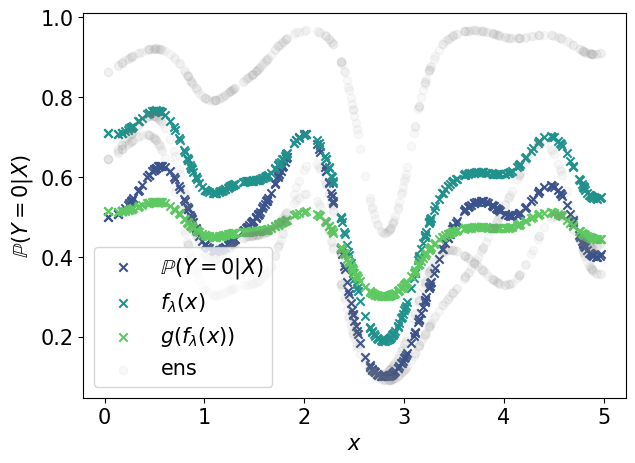

Epoch 1/500: train=0.6689, val=0.6344
Epoch 10/500: train=0.6496, val=0.6143
Epoch 20/500: train=0.6465, val=0.6124
Epoch 30/500: train=0.6459, val=0.6129
Epoch 40/500: train=0.6449, val=0.6128
Epoch 50/500: train=0.6444, val=0.6140
Epoch 60/500: train=0.6428, val=0.6147
Early stopping at epoch 66
Best epoch: 16, Best val loss: 0.6120779037475585
Stopped early at epoch 66
Figure saved to: ../../figures/gp/credal_set_gp_log loss_joint_DirichletCalibrator.png


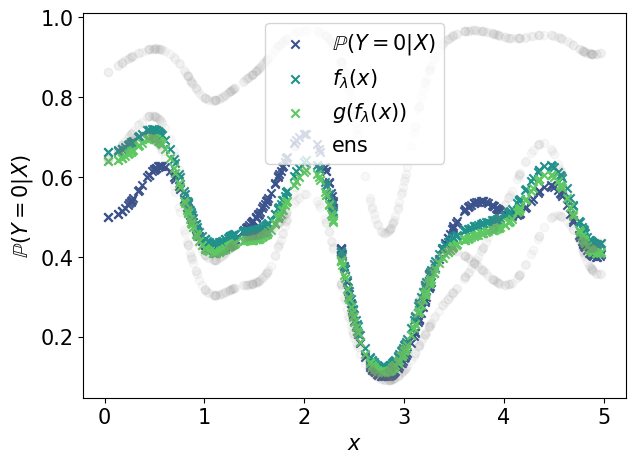

Epoch 1/500: train=0.6766, val=0.6422
Epoch 10/500: train=0.6527, val=0.6131
Epoch 20/500: train=0.6503, val=0.6107
Epoch 30/500: train=0.6492, val=0.6093
Epoch 40/500: train=0.6474, val=0.6092
Epoch 50/500: train=0.6481, val=0.6085
Epoch 60/500: train=0.6466, val=0.6083
Epoch 70/500: train=0.6459, val=0.6086
Epoch 80/500: train=0.6470, val=0.6080
Epoch 90/500: train=0.6455, val=0.6089
Epoch 100/500: train=0.6459, val=0.6083
Epoch 110/500: train=0.6452, val=0.6079
Epoch 120/500: train=0.6444, val=0.6078
Epoch 130/500: train=0.6459, val=0.6080
Epoch 140/500: train=0.6437, val=0.6068
Epoch 150/500: train=0.6441, val=0.6070
Epoch 160/500: train=0.6427, val=0.6059
Epoch 170/500: train=0.6434, val=0.6055
Epoch 180/500: train=0.6429, val=0.6053
Epoch 190/500: train=0.6437, val=0.6046
Epoch 200/500: train=0.6431, val=0.6034
Epoch 210/500: train=0.6431, val=0.6040
Epoch 220/500: train=0.6423, val=0.6029
Epoch 230/500: train=0.6436, val=0.6021
Epoch 240/500: train=0.6422, val=0.6027
Epoch 250/5

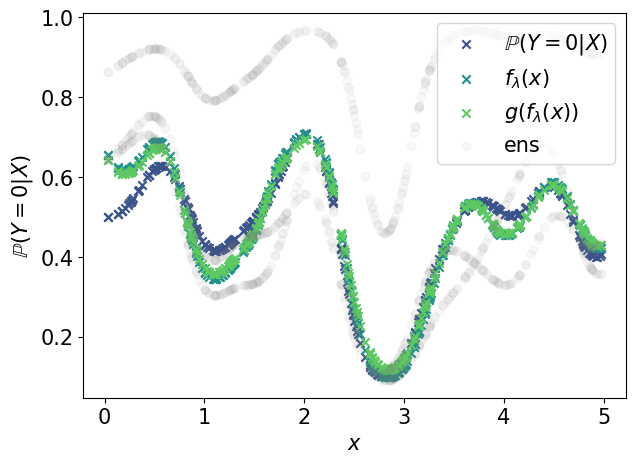

Epoch 1/500: train=0.7308, val=0.6769
Epoch 10/500: train=0.7069, val=1.1495
Epoch 20/500: train=0.7024, val=1.1545
Epoch 30/500: train=0.6996, val=1.1408
Epoch 40/500: train=0.6976, val=1.1171
Epoch 50/500: train=0.6957, val=1.1119
Early stopping at epoch 51
Best epoch: 1, Best val loss: 0.6769056200981141
Stopped early at epoch 51
Figure saved to: ../../figures/gp/credal_set_gp_log loss_joint_LinearCalibrator.png


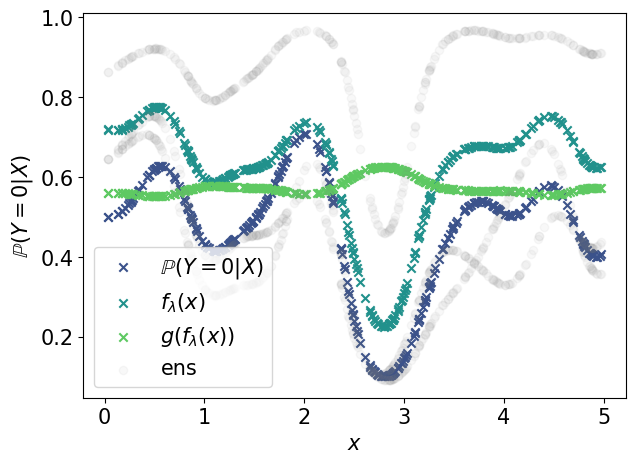

Cycle 1/500: comb_loss=0.6759, cal_loss=0.6696, val=0.6395
Cycle 5/500: comb_loss=0.6548, cal_loss=0.6526, val=0.6180
Cycle 10/500: comb_loss=0.6509, cal_loss=0.6492, val=0.6127
Cycle 15/500: comb_loss=0.6500, cal_loss=0.6487, val=0.6120
Cycle 20/500: comb_loss=0.6486, cal_loss=0.6486, val=0.6110
Cycle 25/500: comb_loss=0.6474, cal_loss=0.6465, val=0.6107
Cycle 30/500: comb_loss=0.6476, cal_loss=0.6476, val=0.6109
Cycle 35/500: comb_loss=0.6468, cal_loss=0.6458, val=0.6110
Cycle 40/500: comb_loss=0.6466, cal_loss=0.6464, val=0.6109
Cycle 45/500: comb_loss=0.6463, cal_loss=0.6465, val=0.6108
Cycle 50/500: comb_loss=0.6461, cal_loss=0.6464, val=0.6106
Cycle 55/500: comb_loss=0.6469, cal_loss=0.6456, val=0.6110
Cycle 60/500: comb_loss=0.6464, cal_loss=0.6449, val=0.6103
Cycle 65/500: comb_loss=0.6460, cal_loss=0.6455, val=0.6107
Cycle 70/500: comb_loss=0.6457, cal_loss=0.6455, val=0.6101
Cycle 75/500: comb_loss=0.6446, cal_loss=0.6443, val=0.6100
Cycle 80/500: comb_loss=0.6468, cal_loss=0

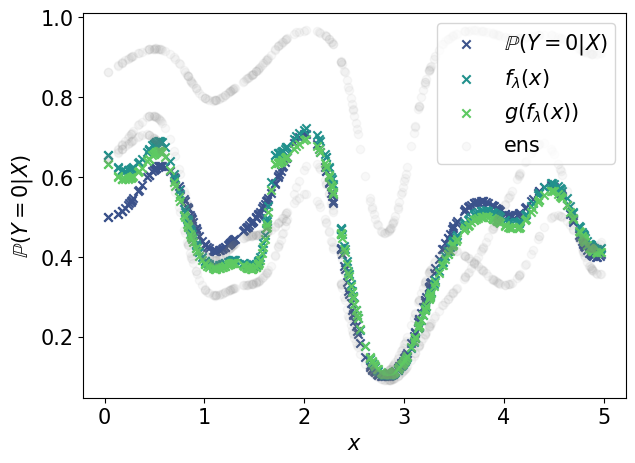

Cycle 1/500: comb_loss=0.6765, cal_loss=0.6735, val=0.6417
Cycle 5/500: comb_loss=0.6560, cal_loss=0.6549, val=0.6185
Cycle 10/500: comb_loss=0.6515, cal_loss=0.6507, val=0.6128
Cycle 15/500: comb_loss=0.6484, cal_loss=0.6500, val=0.6118
Cycle 20/500: comb_loss=0.6480, cal_loss=0.6486, val=0.6104
Cycle 25/500: comb_loss=0.6482, cal_loss=0.6485, val=0.6102
Cycle 30/500: comb_loss=0.6489, cal_loss=0.6478, val=0.6097
Cycle 35/500: comb_loss=0.6475, cal_loss=0.6484, val=0.6095
Cycle 40/500: comb_loss=0.6470, cal_loss=0.6461, val=0.6092
Cycle 45/500: comb_loss=0.6471, cal_loss=0.6466, val=0.6083
Cycle 50/500: comb_loss=0.6467, cal_loss=0.6461, val=0.6095
Cycle 55/500: comb_loss=0.6474, cal_loss=0.6475, val=0.6090
Cycle 60/500: comb_loss=0.6456, cal_loss=0.6455, val=0.6085
Cycle 65/500: comb_loss=0.6462, cal_loss=0.6460, val=0.6081
Cycle 70/500: comb_loss=0.6454, cal_loss=0.6462, val=0.6086
Cycle 75/500: comb_loss=0.6461, cal_loss=0.6433, val=0.6084
Cycle 80/500: comb_loss=0.6446, cal_loss=0

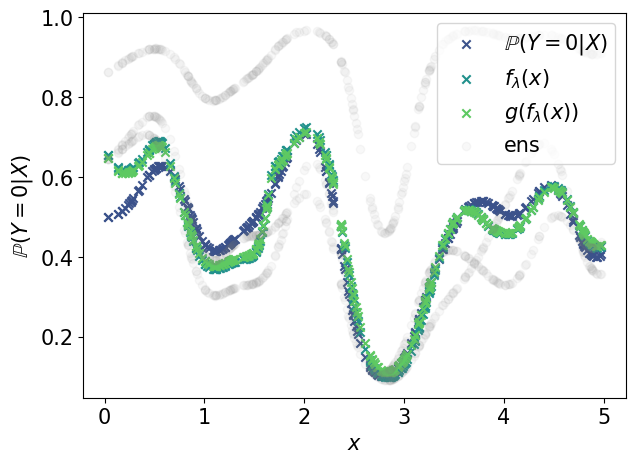

Cycle 1/500: comb_loss=0.6832, cal_loss=0.8720, val=0.6460
Cycle 5/500: comb_loss=0.6541, cal_loss=0.8254, val=0.6177
Cycle 10/500: comb_loss=0.6525, cal_loss=0.8014, val=0.6130
Cycle 15/500: comb_loss=0.6506, cal_loss=0.7849, val=0.6119
Cycle 20/500: comb_loss=0.6493, cal_loss=0.7699, val=0.6114
Cycle 25/500: comb_loss=0.6485, cal_loss=0.7549, val=0.6105
Cycle 30/500: comb_loss=0.6490, cal_loss=0.7422, val=0.6104
Cycle 35/500: comb_loss=0.6478, cal_loss=0.7318, val=0.6099
Cycle 40/500: comb_loss=0.6487, cal_loss=0.7214, val=0.6100
Cycle 45/500: comb_loss=0.6472, cal_loss=0.7129, val=0.6102
Cycle 50/500: comb_loss=0.6468, cal_loss=0.7058, val=0.6099
Cycle 55/500: comb_loss=0.6480, cal_loss=0.6987, val=0.6093
Cycle 60/500: comb_loss=0.6473, cal_loss=0.6922, val=0.6094
Cycle 65/500: comb_loss=0.6454, cal_loss=0.6876, val=0.6098
Cycle 70/500: comb_loss=0.6455, cal_loss=0.6828, val=0.6098
Cycle 75/500: comb_loss=0.6458, cal_loss=0.6791, val=0.6095
Cycle 80/500: comb_loss=0.6461, cal_loss=0

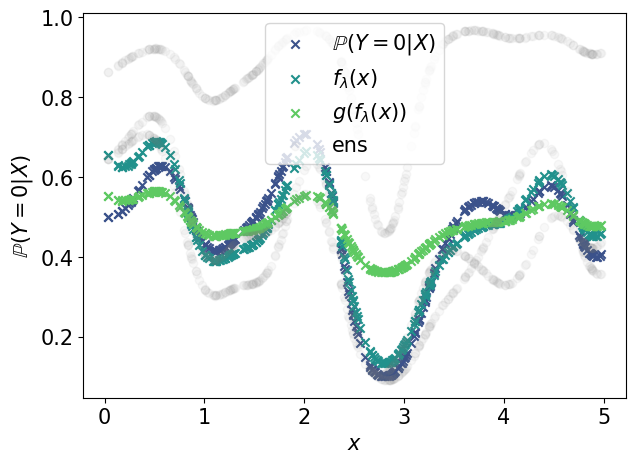

Epoch 1/500: train=0.6794, val=0.6465
Epoch 10/500: train=0.6648, val=0.6308
Epoch 20/500: train=0.6551, val=0.6207
Epoch 30/500: train=0.6509, val=0.6153
Epoch 40/500: train=0.6470, val=0.6126
Epoch 50/500: train=0.6466, val=0.6114
Epoch 60/500: train=0.6458, val=0.6107
Epoch 70/500: train=0.6458, val=0.6105
Epoch 80/500: train=0.6455, val=0.6103
Epoch 90/500: train=0.6472, val=0.6102
Epoch 100/500: train=0.6453, val=0.6101
Epoch 110/500: train=0.6471, val=0.6100
Epoch 120/500: train=0.6463, val=0.6099
Epoch 130/500: train=0.6452, val=0.6099
Epoch 140/500: train=0.6465, val=0.6098
Epoch 150/500: train=0.6466, val=0.6098
Epoch 160/500: train=0.6469, val=0.6097
Epoch 170/500: train=0.6463, val=0.6097
Epoch 180/500: train=0.6468, val=0.6096
Epoch 190/500: train=0.6460, val=0.6096
Epoch 200/500: train=0.6467, val=0.6096
Epoch 210/500: train=0.6463, val=0.6095
Epoch 220/500: train=0.6465, val=0.6095
Epoch 230/500: train=0.6465, val=0.6095
Epoch 240/500: train=0.6470, val=0.6094
Epoch 250/5

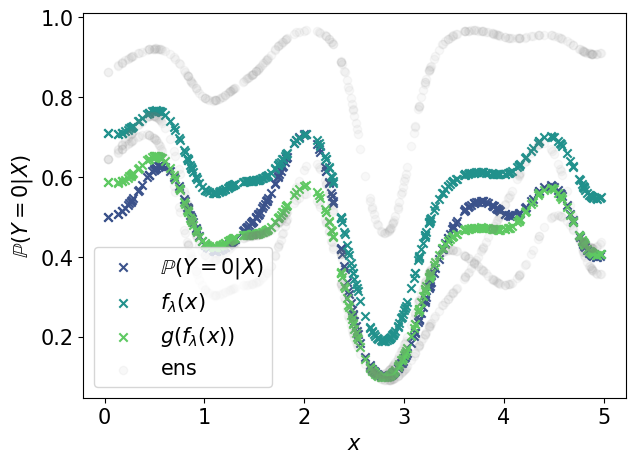

Epoch 1/500: train=0.6812, val=0.6488
Epoch 10/500: train=0.6784, val=0.6486
Epoch 20/500: train=0.6779, val=0.6485
Epoch 30/500: train=0.6774, val=0.6484
Epoch 40/500: train=0.6776, val=0.6483
Epoch 50/500: train=0.6751, val=0.6483
Epoch 60/500: train=0.6757, val=0.6484
Epoch 70/500: train=0.6747, val=0.6484
Epoch 80/500: train=0.6756, val=0.6485
Epoch 90/500: train=0.6741, val=0.6486
Early stopping at epoch 94
Best epoch: 44, Best val loss: 0.6483169198036194
Stopped early at epoch 94
Figure saved to: ../../figures/gp/credal_set_gp_log loss_avg_then_calibrate_TemperatureScalingCalibrator.png


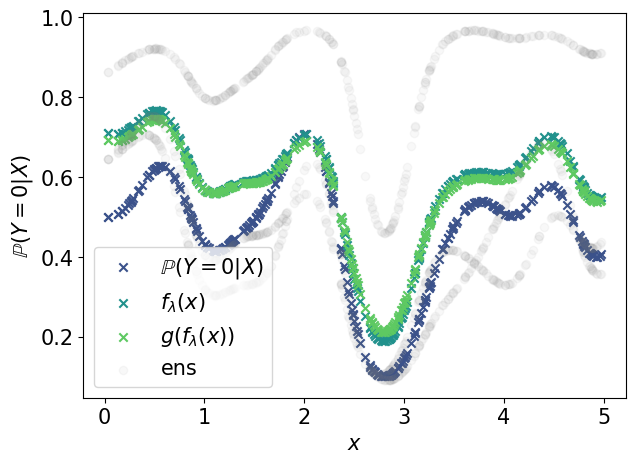

Epoch 1/500: train=0.9707, val=1.0216
Epoch 10/500: train=0.9300, val=0.9752
Epoch 20/500: train=0.8889, val=0.9285
Epoch 30/500: train=0.8506, val=0.8873
Epoch 40/500: train=0.8183, val=0.8516
Epoch 50/500: train=0.7919, val=0.8206
Epoch 60/500: train=0.7695, val=0.7946
Epoch 70/500: train=0.7531, val=0.7728
Epoch 80/500: train=0.7367, val=0.7551
Epoch 90/500: train=0.7268, val=0.7407
Epoch 100/500: train=0.7178, val=0.7294
Epoch 110/500: train=0.7118, val=0.7205
Epoch 120/500: train=0.7072, val=0.7136
Epoch 130/500: train=0.7039, val=0.7081
Epoch 140/500: train=0.7013, val=0.7038
Epoch 150/500: train=0.6991, val=0.7002
Epoch 160/500: train=0.6975, val=0.6971
Epoch 170/500: train=0.6958, val=0.6943
Epoch 180/500: train=0.6942, val=0.6916
Epoch 190/500: train=0.6925, val=0.6891
Epoch 200/500: train=0.6910, val=0.6868
Epoch 210/500: train=0.6895, val=0.6845
Epoch 220/500: train=0.6878, val=0.6822
Epoch 230/500: train=0.6866, val=0.6800
Epoch 240/500: train=0.6849, val=0.6780
Epoch 250/5

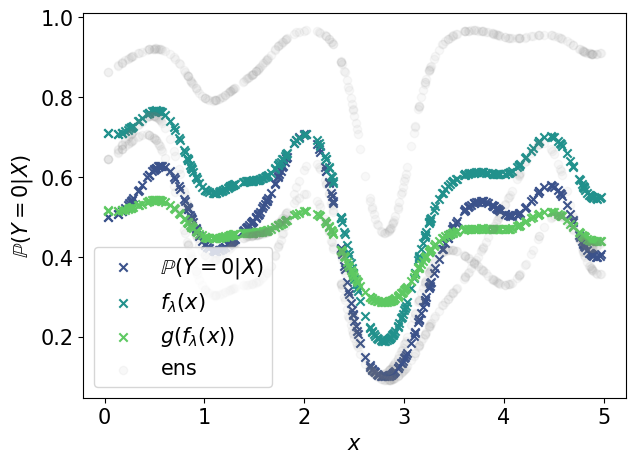

In [8]:
# model = CredalSetCalibrator(comb_model=MLPCalW, cal_model=DirichletCalibrator, in_channels=1,
#                            n_classes=2,n_ensembles=3, hidden_dim=64, hidden_layers=3)

losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator, LinearCalibrator]

# save scores in dict
scores_cal = {}

for loss in losses:
    for train_mode in train_modes:
        for cal_model in cal_models:
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=64,
                hidden_layers=3,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=500,
                lr=1e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=50
            )
            if train_mode not in ["joint", "alternating"]:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
                    title=None,
                    output_path="../../figures/gp/",
                    alpha_comb=1.0,
                    output_pbar="average"
                )
            else:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
                    title=None,
                    output_path="../../figures/gp/",
                    alpha_comb=1.0,
                    output_pbar="weighted"
                )
            plt.show()

### 2. Experiment

According to Vaicenavicious et al.

load config:

In [15]:
config = load_config("../configs/log_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]



split data:

In [3]:
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)


In [13]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

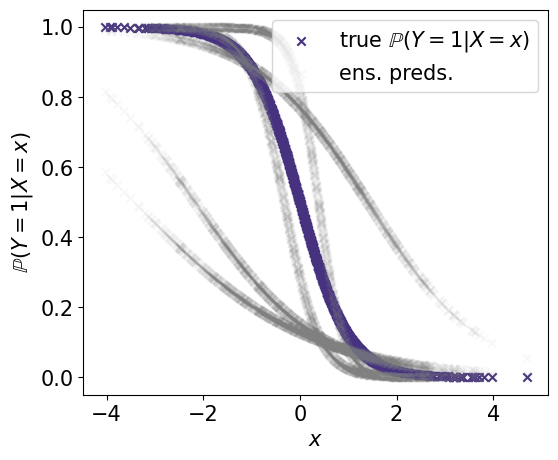

In [14]:
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/log/synthetic_data_log.png", dpi=300)

Epoch 1/500: train=0.2815, val=0.2835
Epoch 10/500: train=0.2338, val=0.2814
Epoch 20/500: train=0.2327, val=0.2842
Epoch 30/500: train=0.2326, val=0.2846
Epoch 40/500: train=0.2325, val=0.2846
Epoch 50/500: train=0.2325, val=0.2852
Early stopping at epoch 55
Best epoch: 5, Best val loss: 0.2761768251657486
Stopped early at epoch 55
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_DirichletCalibrator.png
Epoch 1/500: train=0.2760, val=0.2808
Epoch 10/500: train=0.2337, val=0.2832
Epoch 20/500: train=0.2329, val=0.2850
Epoch 30/500: train=0.2327, val=0.2853
Epoch 40/500: train=0.2326, val=0.2858
Epoch 50/500: train=0.2326, val=0.2857
Early stopping at epoch 54
Best epoch: 4, Best val loss: 0.275347463786602
Stopped early at epoch 54
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_TemperatureScalingCalibrator.png
Cycle 1/500: comb_loss=0.2767, cal_loss=0.2727, val=0.2820
Cycle 5/500: comb_loss=0.2446, cal_loss=0.2407, val=0.2764
Cycle 10/500: comb_los

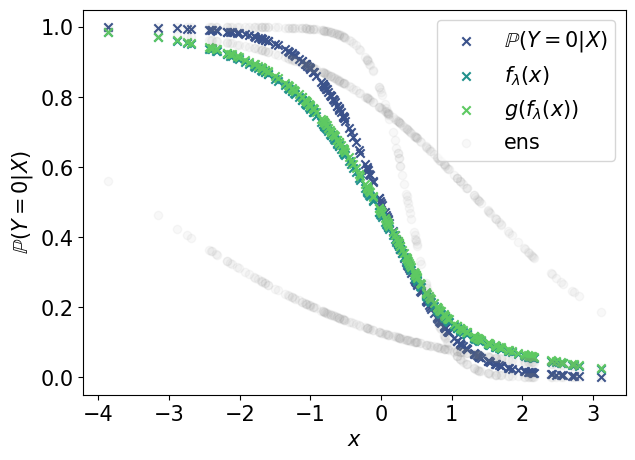

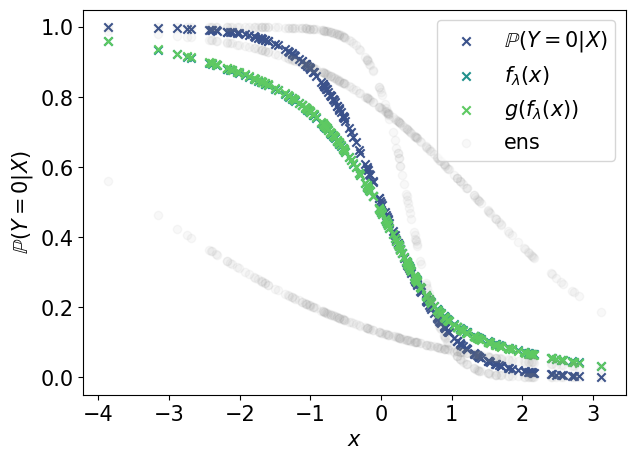

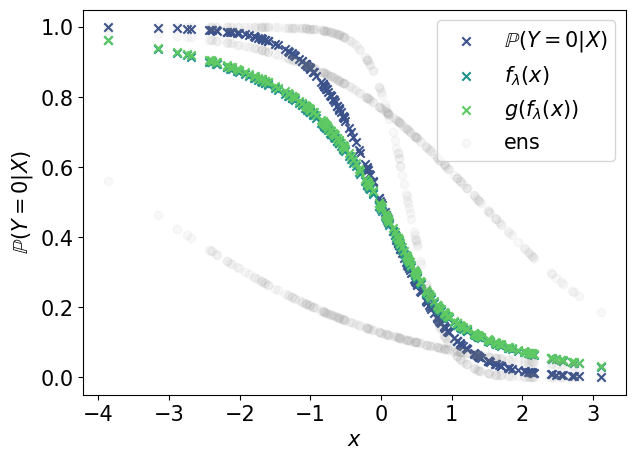

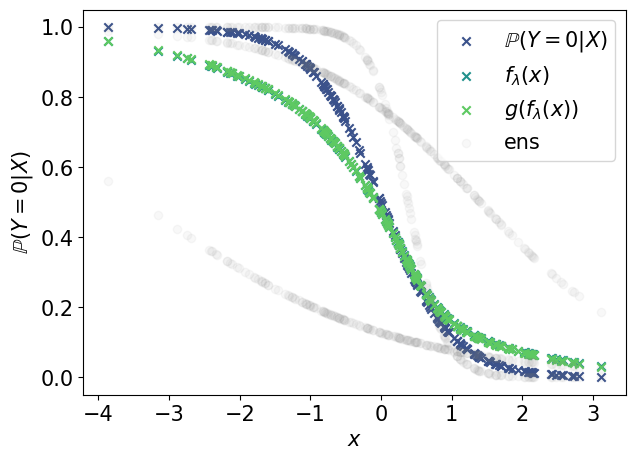

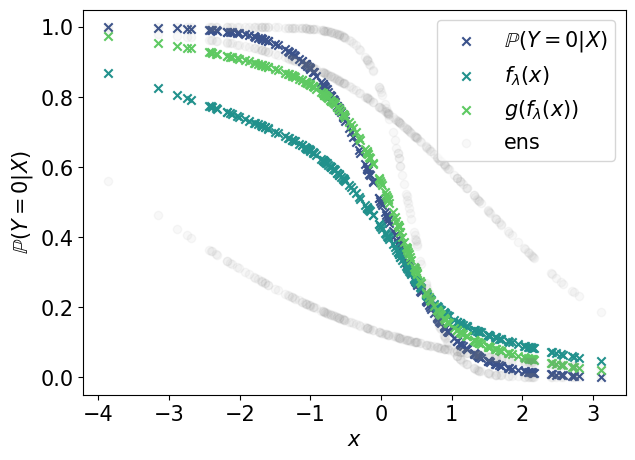

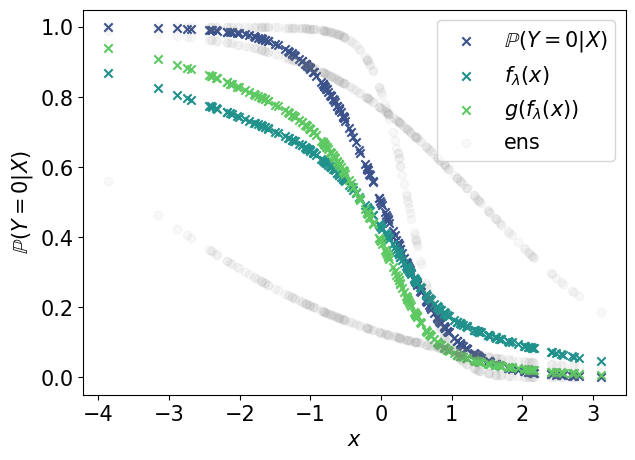

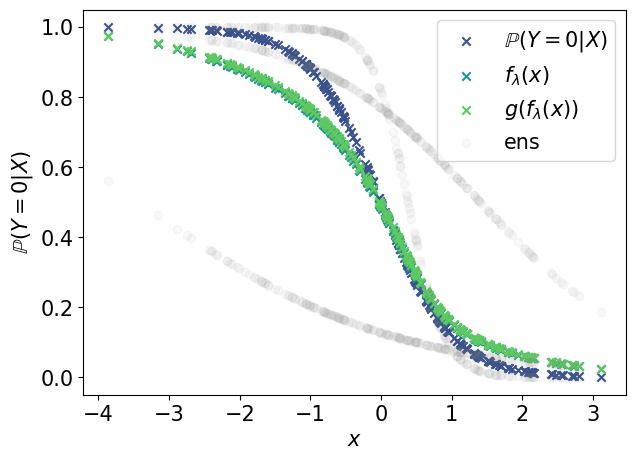

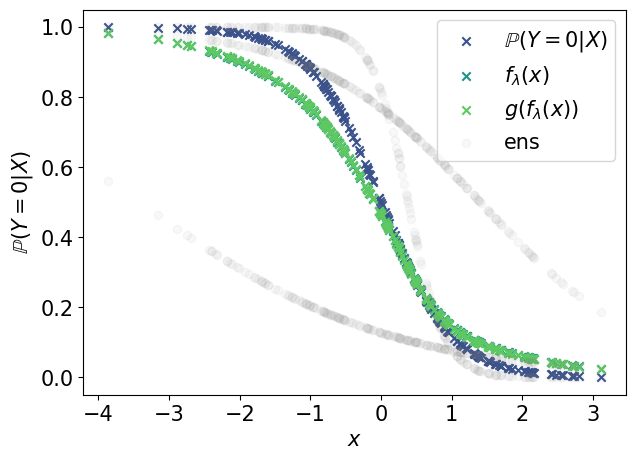

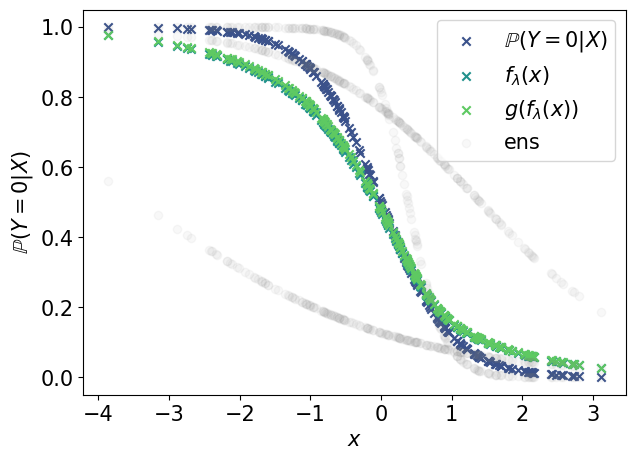

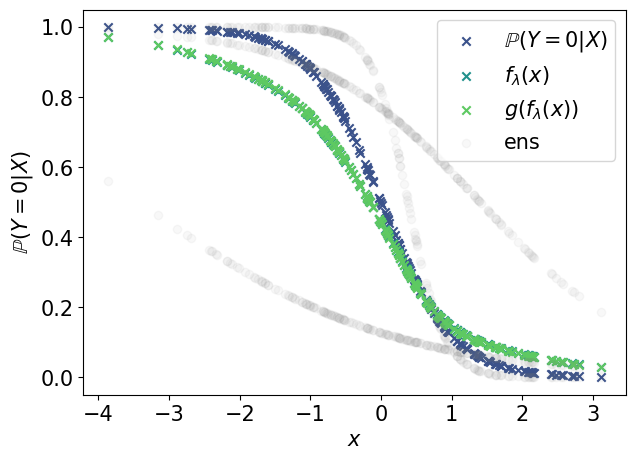

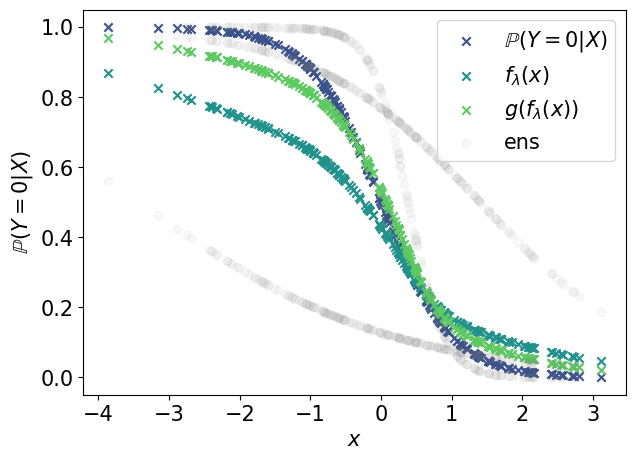

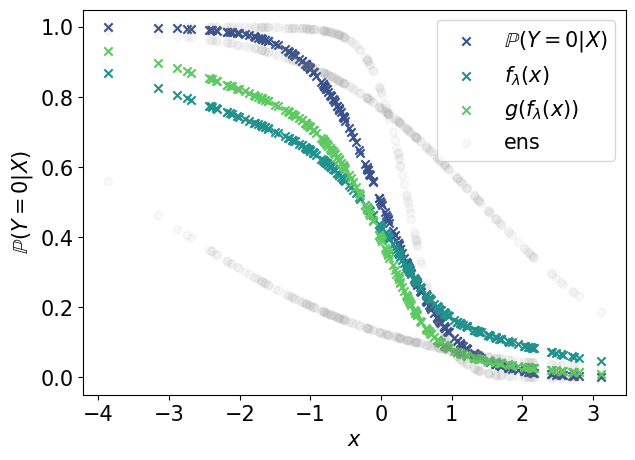

In [22]:
# train model
losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator]

# save scores in dict
scores_cal = {}

for loss_obj in losses:
    loss_name = loss_obj.__class__.__name__
    for train_mode in train_modes:
        for cal_model in cal_models:
            cal_model_name = cal_model.__name__
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=64,
                hidden_layers=2,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss_obj,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=500,
                lr=1e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=50,
            )
            if train_mode not in ["joint", "alternating"]:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="average",
                )
            else:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="weighted",
                )

            with torch.no_grad():
                if train_mode in ["joint", "alternating"]:
                    p_cal_val, p_bar_val, weights_l_val = model(x_val, p_pred_val)

                else:
                    # average first
                    p_bar_val = p_pred_val.mean(dim=1)
                    p_cal_val = model.cal_model(p_bar_val)

            p_cal_numpy = p_cal_val.detach().numpy()
            y_val_np = y_val.detach().numpy()

            # calculate scores
            skce_val = get_skce_ul(
                p_bar=p_cal_val, y=y_val, bw=config["dict_skce"]["bw"]
            )
            ece_kde_val = get_ece_kde(
                p_bar=p_cal_val,
                y=y_val,
                p=config["dict_kde_ece"]["p"],
                bw=config["dict_kde_ece"]["bw"],
            )
            brier_val = brier_obj(p_bar=p_cal_val, y=y_val, params={})
            mmd_val = mmd_kce(p_bar=p_cal_val, y=y_val, bw=config["dict_mmd"]["bw"])

            skce_val = (
                float(torch.abs(skce_val))
                if isinstance(skce_val, torch.Tensor)
                else abs(skce_val)
            )
            ece_kde_val = (
                float(torch.abs(ece_kde_val))
                if isinstance(ece_kde_val, torch.Tensor)
                else abs(ece_kde_val)
            )
            brier_val = (
                float(torch.abs(brier_val))
                if isinstance(brier_val, torch.Tensor)
                else abs(brier_val)
            )
            mmd_val = (
                float(torch.abs(mmd_val))
                if isinstance(mmd_val, torch.Tensor)
                else abs(mmd_val)
            )

            key = (loss_name, train_mode, cal_model_name)
            scores_cal[key] = {
                "skce": skce_val,
                "ece_kde": ece_kde_val,
                "brier": brier_val,
                "mmd": mmd_val,
            }

In [29]:
def save_metric_pivoted(
    scores_cal: dict,
    metric_name: str,
    csv_path: str,
    train_modes=("joint", "alternating", "avg_then_calibrate")
):
    """
    Saves one metric (e.g. 'brier', 'mmd') in a pivoted table:
      - Rows: (loss, calibrator) pairs
      - Columns: each train_mode in train_modes

    scores_cal is a dict like:
      {
        (loss_name, train_mode, cal_model_name): {
            'skce': float,
            'ece_kde': float,
            'brier': float,
            'mmd': float
        },
        ...
      }

    metric_name: the key in the inner dict (e.g. 'brier', 'mmd', 'skce', etc.)
    csv_path: path to write the CSV. We'll ensure the directory exists.
    train_modes: a tuple of column names for the methods.

    The resulting CSV columns are:
      ['(loss,calibrator)', 'joint', 'alternating', 'avg_then_calibrate']
    or some variation, depending on train_modes.
    """
    # 1) Make sure the output directory exists
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # 2) Gather unique (loss_name, cal_model_name) from the dict
    row_keys = set()
    for (loss_name, tm, cal_model_name) in scores_cal.keys():
        row_keys.add((loss_name, cal_model_name))

    # Convert to a sorted list if you prefer sorted rows
    row_keys = sorted(row_keys)

    # 3) We'll build a dict: pivoted_rows[(loss,cal)] = {tm: metric_value, ...}
    pivoted_rows = {}
    for (loss_name, cal_model_name) in row_keys:
        pivoted_rows[(loss_name, cal_model_name)] = {}

    for (loss_name, tm, cal_model_name), metric_dict in scores_cal.items():
        # e.g. metric_dict might have {"brier": 0.1, "mmd":0.05, ...}
        val = metric_dict.get(metric_name, None)
        if val is not None:
            # store in pivoted structure
            pivoted_rows[(loss_name, cal_model_name)][tm] = val

    # 4) Now write to CSV
    #   columns = ["(loss,calibrator)", "joint", "alternating", "avg_then_calibrate", ...]
    columns = ["(loss,cal)"] + list(train_modes)

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        # header row
        writer.writerow(columns)

        # each row = (loss, cal), then the metric for each train_mode
        for (loss_name, cal_model_name) in row_keys:
            row_label = f"({loss_name},{cal_model_name})"
            row_values = [pivoted_rows[(loss_name, cal_model_name)].get(tm, "")
                          for tm in train_modes]
            row = [row_label] + row_values
            writer.writerow(row)

    print(f"Saved pivoted {metric_name} scores to {csv_path}")


In [33]:
save_metric_pivoted(scores_cal, metric_name="brier", csv_path="../results/log/brier_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="skce", csv_path="../results/log/skce_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="ece_kde", csv_path="../results/log/ece_kde_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="mmd", csv_path="../results/log/mmd_scores_log_synthetic.csv")

Saved pivoted brier scores to ../results/log/brier_scores_log_synthetic.csv
Saved pivoted skce scores to ../results/log/skce_scores_log_synthetic.csv
Saved pivoted ece_kde scores to ../results/log/ece_kde_scores_log_synthetic.csv
Saved pivoted mmd scores to ../results/log/mmd_scores_log_synthetic.csv
